In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 10 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/kernel_penalty_sphere/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def H(a, b, sigma=1.0):
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    return 0.5 * np.matmul(a.T, np.matmul(K, a))

In [9]:
def K_mat(b, sigma=1.0):
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    return np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))

In [10]:
def proj_tangential(u, x, eps=1e-5):
    assert np.abs(np.sum(u**2) - 1.0) < eps
    return x - np.inner(x, u)*u

In [11]:
def proj_tangential_mat(u, eps=1e-3):
    #assert (np.abs(np.sum(u**2, axis=1) - 1.0) < eps).all()
    return np.identity(u.shape[0]) - np.matmul(u, u.T)

In [12]:
def proj_tangential_tensor(u, eps=1e-3):
    m, d = u.shape
    T = np.zeros((m, d, d))

    T[:, np.arange(d), np.arange(d)] = 1  # Set diagonal elements to 1

    u_outer = np.einsum('ij,ik->ijk', u, u)  # Compute outer product of u with itself
    T -= u_outer
    
    return T

In [310]:
T.shape

(2, 2, 2)

In [315]:
for i in range(m):
    for j in range(m):
        for k in range(m):
            print(T[i, j, k])
            print(u[j, k] - np.inner(u[i, :], u[j, :]) * u[i, k])

0.09679746678080947
-0.5415064877801247
-0.7759246522782267
-0.465198244893795
-0.7759246522782267
0.18462415724771408
0.3334174297903807
1.0396949350156943
-1.3221980561097353
-1.7891351925410843
-0.6522891230721022
0.0469374035921285
-0.6522891230721022
2.2940756736359558
0.816776566943235
0.6443897433640462


In [314]:
u = np.random.normal(size=(m, INPUT_DIM))
u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)

T = proj_tangential_tensor(u)
np.matmul(T, u.T)

i = np.random.randint(low=0, high=m)


In [13]:
def grad_a_H(a, b, sigma=1.0):
    signs = np.sign(a)
    K = K_mat(a, b, sigma)
    
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    return np.matmul(K, a)

In [14]:
def grad_b_H(a, b, sigma=1.0):
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    outer = np.matmul(a, a.T).reshape(m, m, 1)
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    return np.sum(outer * deltas * K.reshape(m, m, 1), axis=0) / sigma**2

In [15]:
import numpy as np

def compute_matrix_G(a, b, s, P):
    m, d = b.shape

    norm_b = np.linalg.norm(b, axis=1)  # Norm of each row in matrix b

    diff = b[:, np.newaxis, :] - b  # Shape: (m, m, d)
    norm_diff = np.linalg.norm(diff, axis=2)  # Shape: (m, m)
    exp_term = np.exp(-norm_diff**2 / 2)  # Shape: (m, m)

    P_diff = np.einsum('ijk,ik->ijk', P, diff)  # Element-wise multiplication of P and diff
    G = -s * np.sum(a * exp_term[:, :, np.newaxis] * P_diff, axis=1)

    return G

In [293]:
def projected_conic_update(a, b, sigma=1.0):
    signs = np.sign(a)
    deltas = b[:, np.newaxis, :] - b
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    
    # mass updates
    a = (1 + 2 * ETA * signs * np.matmul(K, a)) * a
    
    # positions updates
    P = proj_tangential_tensor(b)
    
    P_delta = np.einsum('ikr,ijr->ijk', P, deltas)  # Element-wise multiplication of P and deltas
    grad = - signs * np.sum(a * K[:, :, np.newaxis] * P_delta, axis=1) / (sigma**2)
    b = b + ETA * grad
    
    # re-normalize particle positions on the sphere
    b = b / np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    
    return a, b, grad

In [335]:
def train(sigma=1.0):
    #signs = np.sign(np.random.normal(size=(m, 1)))
    
    signs = np.array([[1.0], 
                      #[1.0], 
                      [1.0]])#np.ones(shape=(m, 1))
    a = signs / m
    #a = np.ones(shape=(m, 1))
    #b = np.random.uniform(low=0.0, high=1.0, size=(m, INPUT_DIM))
    
    
    #b = np.random.normal(size=(m, INPUT_DIM))
    #b = b / np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    alpha = 5*np.pi / 12
    #beta = 39*np.pi / 80
    b = np.array([[np.cos(alpha), np.sin(alpha)], 
                  #[0., 1.0],
                  [-np.cos(alpha), np.sin(alpha)]])
    
    as_ = [a]
    bs = [b]
    losses = [-H(a, b, sigma)[0, 0]]
    grads = []
    
    mass = np.sqrt(m * np.abs(a))
    us = [signs * mass]
    vs = [mass * b]
    
    for k in range(N_STEPS):
        a, b, grad = projected_conic_update(a, b, sigma)
        #a = a + ETA * grad_a_H(a, b, sigma)
        #b = b + ETA * grad_b_H(a, b, sigma)
        loss = -H(a, b, sigma)[0, 0]
        
        mass = np.sqrt(m * np.abs(a))
        
        as_.append(a)
        bs.append(b)
        us.append(signs * mass)
        vs.append(mass * b)
        losses.append(loss)
        grads.append(grad)
        
        
    return np.array(as_), np.array(bs), np.array(us), np.array(vs), np.array(losses), np.array(grads)

In [349]:
m = 2
INPUT_DIM = 2
ETA = 0.01
sigma = 0.2
N_STEPS = 1000

a, b, u, v, losses, grads = train(sigma=sigma)

/usr/local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2556: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_1728/4283684291.py:4: RuntimeWarning: overflow encountered in matmul
  return 0.5 * np.matmul(a.T, np.matmul(K, a))
/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_1728/2414067133.py:7: RuntimeWarning: overflow encountered in multiply
  a = (1 + 2 * ETA * signs * np.matmul(K, a)) * a
/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_1728/2414067133.py:13: RuntimeWarning: invalid value encountered in multiply
  grad = - signs * np.sum(a * K[:, :, np.newaxis] * P_delta, axis=1) / (sigma**2)


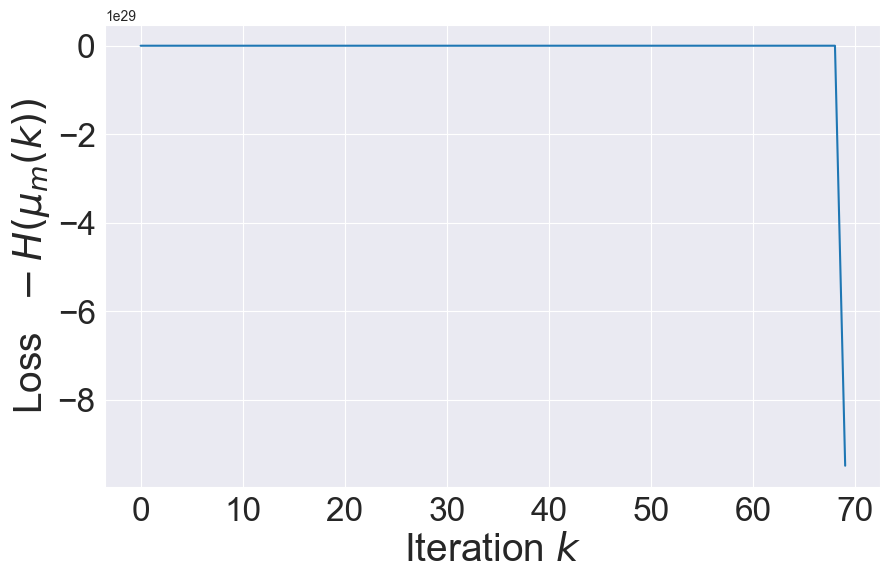

In [350]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
n_iter = 70

plt.plot(np.arange(len(losses))[:n_iter], losses[:n_iter])

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss $\\ -H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

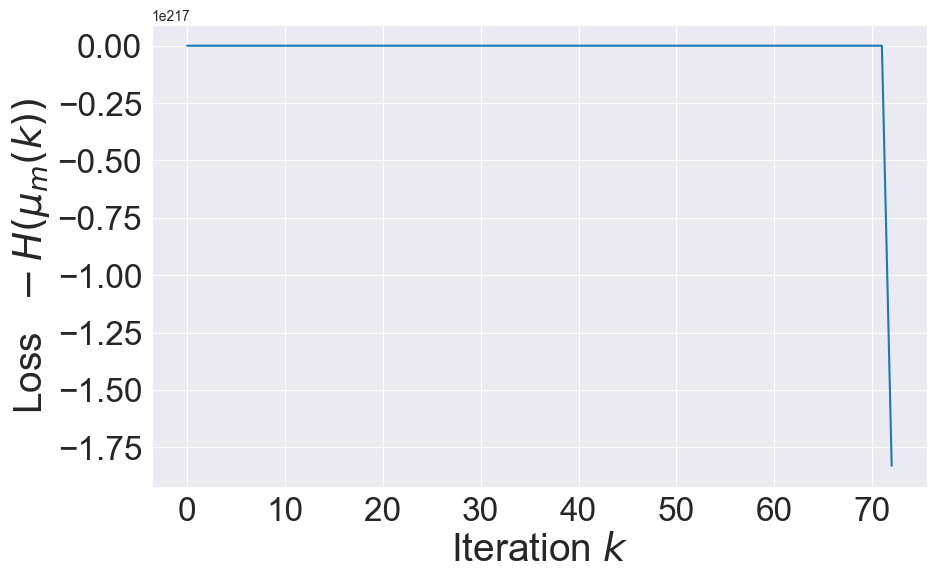

In [351]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses)), losses)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss $\\ -H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

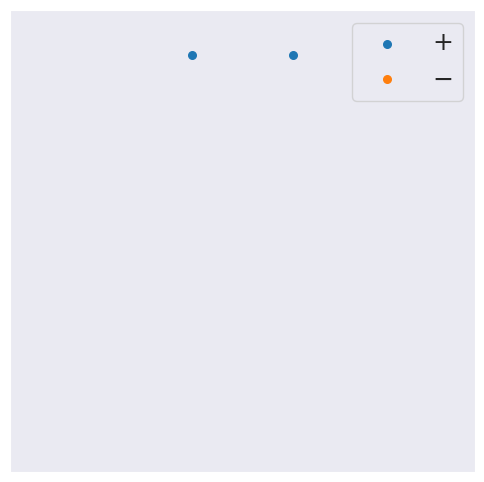

In [352]:
plt.figure(figsize=(6, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
marker = 'o'

signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]
k = 0

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

plt.scatter(b_pos[k, :, 0], b_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
plt.scatter(b_neg[k, :, 0], b_neg[k, :, 1], marker=marker, s=30.0, label='$-$')
#plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

#plt.xlabel('Particle positions', fontsize=28)
#plt.ylabel('Pos / Neg', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([])
plt.yticks([])
#plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [358]:
u = b[0, :, :]
c = a[0, :, :]
grad = grads[0, :, :]
eps = np.sign(c)
deltas = u.reshape(m, 1, INPUT_DIM) - u
outer = np.matmul(c, c.T).reshape(m, m, 1)
K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
print(u.shape)
print(c.shape)
print(grad.shape)

(2, 2)
(2, 1)
(2, 2)


In [360]:
for i in range(m):
    for k in range(INPUT_DIM):
        print(grad[i, k])
        print((eps[i, 0] / (sigma**2)) * (np.sum([c[j, 0] * K[i, j] * u[j, k] for j in range(m)]) - 
                                   np.sum([c[j, 0] * K[i, j] * np.inner(u[i, :], u[j, :]) * u[i, k] 
                                           for j in range(m)])))

-0.21413388842383702
-0.21194008255004979
0.057377002475303245
0.056789173963071864
0.21413388842383702
0.21194008255004979
0.057377002475303245
0.056789173963071864


In [321]:
np.matmul(u, grad.T)

array([[-2.94792554e-17,  3.67847341e-01],
       [ 3.67847341e-01, -2.94792554e-17]])

In [322]:
np.sum(u * grad, axis=1)

array([-2.77555756e-17, -2.77555756e-17])

In [345]:
grad

array([[-9.26466221e-07,  2.48245876e-07],
       [ 9.26466221e-07,  2.48245876e-07]])

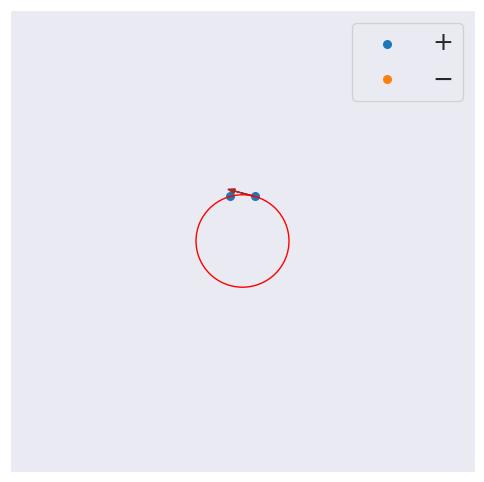

In [356]:
plt.figure(figsize=(6, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
marker = 'o'

signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]
k = 0
scale = 2.0

plt.xlim(-5.0, 5.0)
plt.ylim(-5.0, 5.0)

grad = scale * grads[k]


plt.scatter(b_pos[k, :, 0], b_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
plt.scatter(b_neg[k, :, 0], b_neg[k, :, 1], marker=marker, s=30.0, label='$-$')
plt.arrow(b_pos[k, 0, 0], b_pos[k, 0, 1], grad[0, 0], grad[0, 1], color='brown', head_width=0.1)

ax = plt.gca()
#ax.annotate("", xy=(b_pos[k, 0, 0], b_pos[k, 0, 1]), xytext=(grad[0, 0], grad[0, 1]),
#            arrowprops=dict(arrowstyle="<-"))
#plt.arrow(b_pos[k, 1, 0], b_pos[k, 1, 1], grad[1, 0], grad[1, 1], color='brown')
#plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

circle = plt.Circle((0, 0), 1.0, color='red', fill=False)

ax.add_patch(circle)

#plt.xlabel('Particle positions', fontsize=28)
#plt.ylabel('Pos / Neg', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([])
plt.yticks([])
#plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [299]:
print(np.sum(pos))
print(np.sum(neg))

2
0


In [300]:
np.sqrt(np.sum((b[70, :, :] - b[0, :, :])**2, axis=1))

array([0.34210498, 0.34210498])

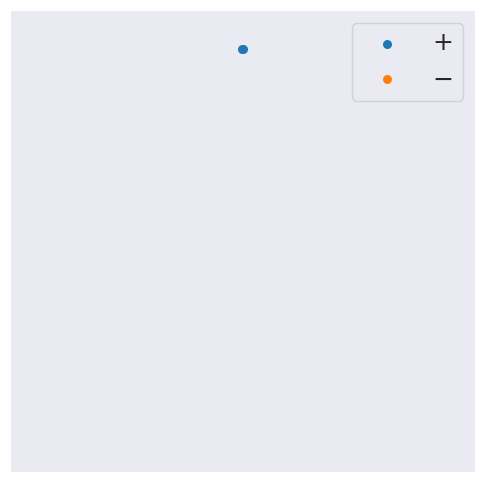

In [357]:
plt.figure(figsize=(6, 6))
#marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
marker = 'o'

signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]
k = 60

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

plt.scatter(b_pos[k, :, 0], b_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
plt.scatter(b_neg[k, :, 0], b_neg[k, :, 1], marker=marker, s=30.0, label='$-$')
#plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

#plt.xlabel('Particle positions', fontsize=28)
#plt.ylabel('Pos / Neg', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([])
plt.yticks([])
#plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [ ]:
## marker = 'o'
signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]

marker = 'o'
for k in range(len(b)):
    plt.figure(figsize=(6, 6))
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)

    plt.scatter(b_pos[k, :, 0], b_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
    plt.scatter(b_neg[k, :, 0], b_neg[k, :, 1], marker=marker, s=30.0, label='$-$')

    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize=18)

    plt.savefig(os.path.join(FIGURES_DIR, 'attraction-repulsion_{}.png'.format(k)), bbox_inches='tight')
    plt.close()

In [267]:
def f(s, sigma=0.08):
    return np.exp(s/(sigma**2)) * (1 - s**2)

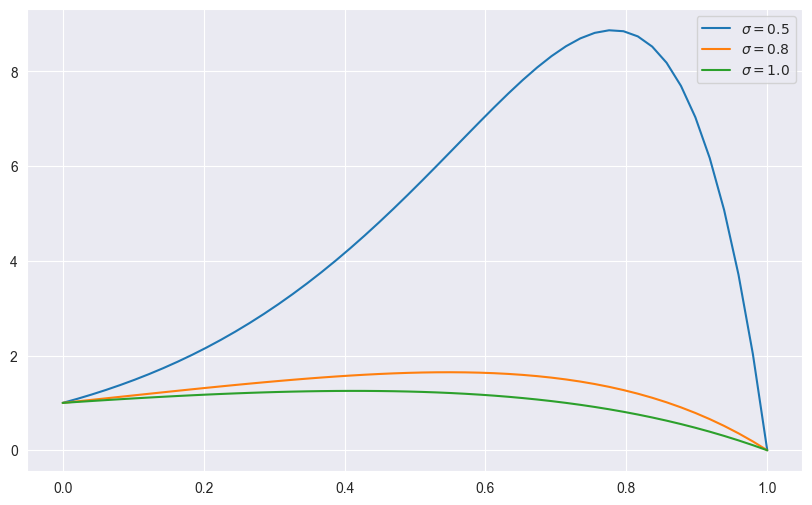

In [275]:
plt.figure(figsize=(10, 6))

xs = np.linspace(start=0., stop=1.0, num=50, endpoint=True)
#sigmas = [0.001, 0.005, 0.01, 0.05, 0.08, 1.0]
sigmas = [0.5, 0.8, 1.0]
for sigma in sigmas:
    ys = f(xs, sigma)
    plt.plot(xs, ys, label='$\\sigma={}$'.format(sigma))

plt.legend()
plt.show()